In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

In [ ]:

B = 200
N = 20
X = np.random.randn(N)


Bootstraping code and visualization

sample mean of X: 0.581335772811788
bootstrap mean of X: 0.5858619243281639


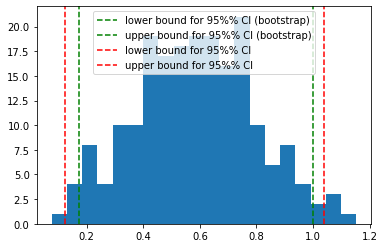

In [ ]:

print("sample mean of X:", X.mean())

individual_estimates = np.empty(B)
for b in range(B):
  sample = np.random.choice(X, size=N)
  individual_estimates[b] = sample.mean()


bmean = individual_estimates.mean()
bstd = individual_estimates.std()
lower = bmean + norm.ppf(0.025)*bstd # norm.ppf(0.025) == -1.96
upper = bmean + norm.ppf(0.975)*bstd # norm.ppf(0.975) == +1.96

# traditional way of calculating CI
lower2 = X.mean() + norm.ppf(0.025)*X.std()/np.sqrt(N)
upper2 = X.mean() + norm.ppf(0.975)*X.std()/np.sqrt(N)

print("bootstrap mean of X:", bmean)

plt.hist(individual_estimates, bins=20)
plt.axvline(x=lower, linestyle='--', color='g', label="lower bound for 95%% CI (bootstrap)")
plt.axvline(x=upper, linestyle='--', color='g', label="upper bound for 95%% CI (bootstrap)")
plt.axvline(x=lower2, linestyle='--', color='r', label="lower bound for 95%% CI")
plt.axvline(x=upper2, linestyle='--', color='r', label="upper bound for 95%% CI")
plt.legend()
plt.show()

Bagging on Regression tree

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle


Regression tree 

score for 1 tree: 0.9891608363036727


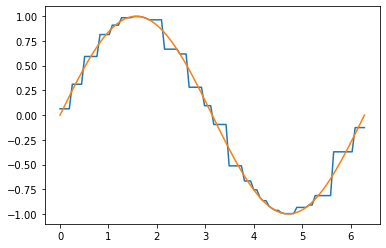

In [ ]:
T = 100
x_axis = np.linspace(0, 2*np.pi, T)
y_axis = np.sin(x_axis)

# get the training data
N = 30
idx = np.random.choice(T, size=N, replace=False)
Xtrain = x_axis[idx].reshape(N, 1)
Ytrain = y_axis[idx]

# try a lone decision tree
model = DecisionTreeRegressor()
model.fit(Xtrain, Ytrain)
prediction = model.predict(x_axis.reshape(T, 1))
print("score for 1 tree:", model.score(x_axis.reshape(T, 1), y_axis))

# plot the lone decision tree's predictions
plt.plot(x_axis, prediction)
plt.plot(x_axis, y_axis)
plt.show()

With bagging

In [ ]:
class BaggedTreeRegressor:
  def __init__(self, B):
    self.B = B

  def fit(self, X, Y):
    N = len(X)
    self.models = []
    for b in range(self.B):
      idx = np.random.choice(N, size=N, replace=True)
      Xb = X[idx]
      Yb = Y[idx]

      model = DecisionTreeRegressor()
      model.fit(Xb, Yb)
      self.models.append(model)

  def predict(self, X):
    predictions = np.zeros(len(X))
    for model in self.models:
      predictions += model.predict(X)
    return predictions / self.B

  def score(self, X, Y):
    d1 = Y - self.predict(X)
    d2 = Y - Y.mean()
    return 1 - d1.dot(d1) / d2.dot(d2)




We can observe that there is improvement when we are doing bagging for regression over normal case.

score for bagged tree: 0.9902213509510125


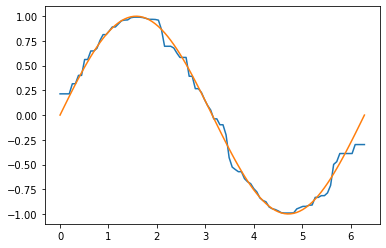

In [ ]:
model = BaggedTreeRegressor(200)
model.fit(Xtrain, Ytrain)
print("score for bagged tree:", model.score(x_axis.reshape(T, 1), y_axis))
prediction = model.predict(x_axis.reshape(T, 1))

# plot the bagged regressor's predictions
plt.plot(x_axis, prediction)
plt.plot(x_axis, y_axis)
plt.show()

Bagging for Classification 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle



In [ ]:
def plot_decision_boundary(X, model):
  h = .02  # step size in the mesh
  # create a mesh to plot in
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))


  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, m_max]x[y_min, y_max].
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.contour(xx, yy, Z, cmap=plt.cm.Paired)


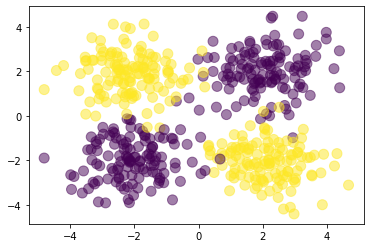

score for 1 tree: 1.0


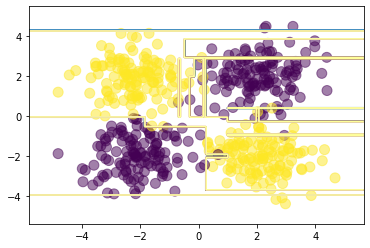

In [ ]:
np.random.seed(10)

# create the data
N = 500
D = 2
X = np.random.randn(N, D)

# 2 gaussians
# sep = 1.5
# X[:N/2] += np.array([sep, sep])
# X[N/2:] += np.array([-sep, -sep])
# Y = np.array([0]*(N/2) + [1]*(N/2))

# noisy XOR
sep = 2
X[:125] += np.array([sep, sep])
X[125:250] += np.array([sep, -sep])
X[250:375] += np.array([-sep, -sep])
X[375:] += np.array([-sep, sep])
Y = np.array([0]*125 + [1]*125 + [0]*125 + [1]*125)

# plot the data
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plt.show()

# lone decision tree
model = DecisionTreeClassifier()
model.fit(X, Y)
print("score for 1 tree:", model.score(X, Y))

# plot data with boundary
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(X, model)
plt.show()

Now, lets do it with bagging

score for bagged model: 0.968


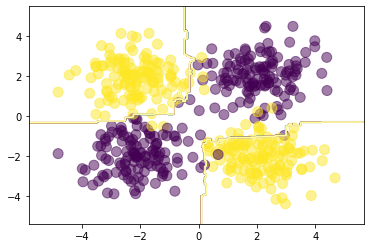

In [ ]:
class BaggedTreeClassifier:
  def __init__(self, B):
    self.B = B

  def fit(self, X, Y):
    N = len(X)
    self.models = []
    for b in range(self.B):
      idx = np.random.choice(N, size=N, replace=True)
      Xb = X[idx]
      Yb = Y[idx]

      model = DecisionTreeClassifier(max_depth=2)
      model.fit(Xb, Yb)
      self.models.append(model)

  def predict(self, X):
    # no need to keep a dictionary since we are doing binary classification
    predictions = np.zeros(len(X))
    for model in self.models:
      predictions += model.predict(X)
    return np.round(predictions / self.B)

  def score(self, X, Y):
    P = self.predict(X)
    return np.mean(Y == P)


model = BaggedTreeClassifier(200)
model.fit(X, Y)

print("score for bagged model:", model.score(X, Y))

# plot data with boundary
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(X, model)
plt.show()